# Imports

In [2]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip -q install ktrain requests

In [4]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 83.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain 
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences 
from spacy.training import offsets_to_biluo_tags

# Utils

In [6]:
nlp = spacy.load('pt_core_news_sm')

entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds,preds2):
    #print(preds)
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrencia que não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,preds2,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    ent = text[p2[0]:p2[1]]
                    label = p2[2]
                    #print(ent)
                    text_aux = text[p1[1]:]
                    idx0 = p1[0]
                    idx1 = p1[1]
                    flag = 0
                    while flag == 0:
                        flag = 1
                        span = get_span(text_aux,label,ent)
                        #print(span)
                        for p3 in preds:
                            # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                            if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                                #print('p3[0]:',p3[0])
                                #print('p3[1]:',p3[1])
                                flag = 0
                                text_aux = text[p3[1]:]
                                #print(text_aux)
                                idx0 = p3[0]
                                idx1 = p3[1]
                                # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                                # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                                #break
                    if(span['start']!=0 and span['end']!=0):
                        #print('trocou p1: ', p1)
                        #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                        preds.remove(p2)
                        preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                        return preds,preds2,0
                    else:
                        #print('removeu p1: ', p1)
                        preds2.append(p1)
                        preds.remove(p1)
                        return preds,preds2,0
    return preds,preds2,1

def mix_final_preds(final_preds):
    for i in range(len(final_preds)):
        for j in range(i,len(final_preds)):
            for p1 in final_preds[i]:
                flag = 1
                for p2 in final_preds[j]:
                    if ((p2[0]<=p1[0]<=p2[1]) or (p2[0]<=p1[1]<=p2[1]) or (p1[0]<=p2[0]<=p1[1]) or (p1[0]<=p2[1]<=p1[1])):
                        flag = 0
                if flag==1:
                    final_preds[j].append(p1)
    return final_preds

def rec_ajust_preds(text,preds):
    final_preds = []
    preds2 = []
    teste = 0
    while teste != 1:
        preds,preds2, teste = ajust_preds(text,preds,preds2)
    if(preds2==[]):
        return [preds]
    else:
        final_preds.append(preds)
        for pred in rec_ajust_preds(text,preds2):
            final_preds.append(pred)
        # Junta as predições que não sobresaeem uma da outra
        return mix_final_preds(final_preds)

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [7]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))
        
    nlp = spacy.load('pt_core_news_sm')
    preds = get_list_spans(texto,labels)

    conll=''
    for pred in preds:

        text = re.sub('\n', ' ', texto)
        doc = nlp(text)

        tags = offsets_to_biluo_tags(doc, pred)

        for i in range(len(doc)):
            if tags[i][0] == 'U':
                conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
            elif tags[i][0] == 'L':
                conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
            else:
                conll += doc[i].text + ' ' + tags[i] + '\n'
              
        conll+='\n'

    return conll

In [8]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'
  return conll_conc+'\n'

In [9]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

# Carregando dados

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# import gdown

# url = 'https://drive.google.com/drive/folders/1AJitYBCAc-vI5kgcAGEVV5oD4q9EmVoZ?usp=sharing'

# gdown.download_folder(url)

In [12]:
#CONLL BASE COM 783 atos pelo GPT Mais os atos combinados em usa porcentagems
VAL_DATA = "/content/drive/MyDrive/tccF/val_conll.conll"
BASE_DATA_10 = "/content/drive/MyDrive/Conll_IT/Combined/conll_110.conll"
BASE_DATA_20 = "/content/drive/MyDrive/Conll_IT/Combined/conll_120.conll"
BASE_DATA_30 = "/content/drive/MyDrive/Conll_IT/Combined/conll_130.conll"
BASE_DATA_40 = "/content/drive/MyDrive/Conll_IT/Combined/conll_140.conll"
BASE_DATA_50 = "/content/drive/MyDrive/Conll_IT/Combined/conll_150.conll"
BASE_DATA_60 = "/content/drive/MyDrive/Conll_IT/Combined/conll_160.conll"
BASE_DATA_70 = "/content/drive/MyDrive/Conll_IT/Combined/conll_170.conll"
BASE_DATA_80 = "/content/drive/MyDrive/Conll_IT/Combined/conll_180.conll"
BASE_DATA_90 = "/content/drive/MyDrive/Conll_IT/Combined/conll_190.conll"
BASE_DATA_100 = "/content/drive/MyDrive/Conll_IT/Combined/conll_200.conll"

In [13]:
# Dataframe que servirá para o treinamento iterativo dos modelos
# df_test = pd.read_csv('/content/tccF/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

,id,id_ato,texto,label
0,444,631-R47,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
1,51,634-R93,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"{'numero_contrato': ['45384/2021', '45384/2021..."
2,140,628-R103,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"{'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE..."
3,242,630-R76,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"{'natureza_despesa': ['339039'], 'numero_contr..."
4,624,671-R49,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,{'partes_contratuais': ['Companhia de Planejam...
...,...,...,...,...
375,273,637-R130,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,{'partes_contratuais': ['SECRETARIA DE ESTADO ...
376,594,626-R141,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"{'natureza_despesa': ['449052'], 'partes_contr..."
377,704,639-R143,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
378,436,631-R35,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...


In [14]:
print(len(df_test))

380


In [15]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


In [16]:
samples[0]

'EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04001-0000000210/2021-91. Das Partes: INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS na qualidade de CONTRATANTE, COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA na qualidade de CONTRATADA. Do Objeto: CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO. DO VALOR: R$ 55,843.60 (cinquenta e cinco mil e oitocentos e quarenta e três reais e sessenta centavos) e correrá à conta de dotações orçamentárias consignadas no orçamento corrente - Lei Orçamentária Anual. DA DOTAÇÃO ORÇAMENTÁRIA: A despesa correrá à conta da seguinte Dotação Orçamentária: DOTAÇÃO ORÇAMENTÁRIA: UO:19212; PROGRAMA DE TRABALHO: 10122620361957, FONTE DE RECURSO: 220000000; UG: 140202; GESTÃO: 14202; EMPENHO 2021NE0/0129, DATADO DE: 21/07/2021, VALOR DO EMPENHO: R$ 55,843.60 (cinquenta

# Treinando Modelos

## 10

In [17]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_10,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 80s 8s/step - loss: 0.8365 - val_loss: 0.7670
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.5074 - val_loss: 0.6093
Epoch 3/10
9/9 [==============================] - 68s 8s/step - loss: 0.4120 - val_loss: 0.4551
Epoch 4/10
9/9 [==============================] - 68s 8s/step - loss: 0.3451 - val_loss: 0.3728
Epoch 5/10
9/9 [==============================] - 68s 8s/step - loss: 0.3010 - val_loss: 0.3102
Epoch 6/10
9/9 [==============================] - 68s 8s/step - loss: 0.2745 - val_loss: 0.3175
Epoch 7/10
9/9 [==============================] - 68s 8s/step - loss: 0.2469 - val_loss: 0.2757
Epoch 8/10
9/9 [==============================] - 68s 8s/step - loss: 0.2229 - val_loss: 0.2765
Epoch 9/10
9/9 [==============================] - 68s 8s/step - loss: 0.2055 - val_los

In [18]:
dict10 = get_entities_from_prediction(predictor.predict(samples))

In [19]:
learner.validate()

   F1:  39.83
                          precision    recall  f1-score   support

data_assinatura_contrato       0.67      0.27      0.39       243
        natureza_despesa       0.82      0.54      0.65       275
            nota_empenho       0.97      0.58      0.73       349
         numero_contrato       0.93      0.66      0.77       458
         objeto_contrato       0.09      0.33      0.14       386
      partes_contratuais       0.19      0.09      0.12       794
            processo_gdf       0.68      0.71      0.70       413
       programa_trabalho       0.78      0.50      0.61       359
    unidade_orcamentaria       0.87      0.18      0.30       294
          valor_contrato       0.91      0.71      0.80       367
       vigencia_contrato       0.02      0.05      0.03       330

               micro avg       0.39      0.40      0.40      4268
               macro avg       0.63      0.42      0.48      4268
            weighted avg       0.59      0.40      0.45     

0.3983364140480592

In [20]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta10.pkl", "wb") as f:
    pkl.dump(dict10, f)

## 20

In [21]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_20,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
10/10 [==============================] - 83s 7s/step - loss: 0.8467 - val_loss: 0.7705
Epoch 2/10
10/10 [==============================] - 72s 7s/step - loss: 0.5055 - val_loss: 0.5749
Epoch 3/10
10/10 [==============================] - 72s 7s/step - loss: 0.3983 - val_loss: 0.4348
Epoch 4/10
10/10 [==============================] - 72s 7s/step - loss: 0.3319 - val_loss: 0.3536
Epoch 5/10
10/10 [==============================] - 72s 7s/step - loss: 0.2924 - val_loss: 0.3100
Epoch 6/10
10/10 [==============================] - 72s 8s/step - loss: 0.2666 - val_loss: 0.3085
Epoch 7/10
10/10 [==============================] - 72s 7s/step - loss: 0.2457 - val_loss: 0.2968
Epoch 8/10
10/10 [==============================] - 72s 7s/step - loss:

In [22]:
dict20 = get_entities_from_prediction(predictor.predict(samples))

In [23]:
learner.validate()

   F1:  39.60
                          precision    recall  f1-score   support

data_assinatura_contrato       0.71      0.33      0.45       243
        natureza_despesa       0.94      0.56      0.70       275
            nota_empenho       0.97      0.57      0.72       349
         numero_contrato       0.90      0.83      0.86       458
         objeto_contrato       0.04      0.16      0.06       386
      partes_contratuais       0.13      0.14      0.14       794
            processo_gdf       0.78      0.86      0.82       413
       programa_trabalho       0.67      0.55      0.61       359
    unidade_orcamentaria       0.93      0.53      0.68       294
          valor_contrato       0.91      0.62      0.73       367
       vigencia_contrato       0.02      0.05      0.03       330

               micro avg       0.35      0.45      0.40      4268
               macro avg       0.64      0.47      0.53      4268
            weighted avg       0.58      0.45      0.49     

0.39603353097526073

In [24]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta20.pkl", "wb") as f:
    pkl.dump(dict20, f)

## 30

In [18]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_30,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
11/11 [==============================] - 87s 7s/step - loss: 0.7873 - val_loss: 0.7224
Epoch 2/10
11/11 [==============================] - 75s 7s/step - loss: 0.4502 - val_loss: 0.4629
Epoch 3/10
11/11 [==============================] - 76s 7s/step - loss: 0.3491 - val_loss: 0.3493
Epoch 4/10
11/11 [==============================] - 76s 7s/step - loss: 0.2985 - val_loss: 0.2872
Epoch 5/10
11/11 [==============================] - 76s 7s/step - loss: 0.2581 - val_loss: 0.2907
Epoch 6/10
11/11 [==============================] - 76s 7s/step - loss: 0.2330 - val_loss: 0.2768
Epoch 7/10
11/11 [==============================] - 76s 7s/step - loss: 0.2207 - val_loss: 0.2573
Epoch 8/10
11/11 [==============================] - 76s 7s/step - loss: 0.2052 - val_loss: 0.2483
Epoch 9/10
11/11 [==============================] - 76s 7s/step - loss

In [19]:
dict30 = get_entities_from_prediction(predictor.predict(samples))

In [20]:
learner.validate()

   F1:  42.61
                          precision    recall  f1-score   support

data_assinatura_contrato       0.86      0.39      0.53       243
        natureza_despesa       0.88      0.60      0.71       275
            nota_empenho       0.97      0.57      0.72       349
         numero_contrato       0.93      0.74      0.83       458
         objeto_contrato       0.09      0.34      0.14       386
      partes_contratuais       0.20      0.17      0.18       794
            processo_gdf       0.76      0.77      0.76       413
       programa_trabalho       0.77      0.51      0.61       359
    unidade_orcamentaria       0.96      0.45      0.61       294
          valor_contrato       0.94      0.63      0.75       367
       vigencia_contrato       0.01      0.01      0.01       330

               micro avg       0.40      0.45      0.43      4268
               macro avg       0.67      0.47      0.53      4268
            weighted avg       0.62      0.45      0.50     

0.4261138067931187

In [21]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta30.pkl", "wb") as f:
    pkl.dump(dict30, f)

## 40

In [22]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_40,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 91s 7s/step - loss: 0.8280 - val_loss: 0.7036
Epoch 2/10
12/12 [==============================] - 80s 7s/step - loss: 0.4534 - val_loss: 0.4499
Epoch 3/10
12/12 [==============================] - 80s 7s/step - loss: 0.3496 - val_loss: 0.3424
Epoch 4/10
12/12 [==============================] - 80s 7s/step - loss: 0.2943 - val_loss: 0.3109
Epoch 5/10
12/12 [==============================] - 80s 7s/step - loss: 0.2728 - val_loss: 0.2557
Epoch 6/10
12/12 [==============================] - 80s 7s/step - loss: 0.2382 - val_loss: 0.2401
Epoch 7/10
12/12 [==============================] - 80s 7s/step - loss: 0.2201 - val_loss: 0.2386
Epoch 8/10
12/12 [==============================] - 80s 7s/step - loss:

In [23]:
dict40 = get_entities_from_prediction(predictor.predict(samples))

In [24]:
learner.validate()

   F1:  46.92
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.60      0.68       243
        natureza_despesa       0.92      0.67      0.77       275
            nota_empenho       0.98      0.59      0.74       349
         numero_contrato       0.89      0.83      0.86       458
         objeto_contrato       0.06      0.18      0.09       386
      partes_contratuais       0.16      0.19      0.17       794
            processo_gdf       0.82      0.84      0.83       413
       programa_trabalho       0.82      0.62      0.71       359
    unidade_orcamentaria       0.85      0.60      0.70       294
          valor_contrato       0.92      0.77      0.84       367
       vigencia_contrato       0.04      0.09      0.06       330

               micro avg       0.43      0.51      0.47      4268
               macro avg       0.66      0.54      0.59      4268
            weighted avg       0.60      0.51      0.55     

0.46918064309368657

In [25]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta40.pkl", "wb") as f:
    pkl.dump(dict40, f)

## 50

In [17]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_50,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 96s 7s/step - loss: 0.7892 - val_loss: 0.6630
Epoch 2/10
12/12 [==============================] - 84s 7s/step - loss: 0.4133 - val_loss: 0.4262
Epoch 3/10
12/12 [==============================] - 84s 7s/step - loss: 0.3263 - val_loss: 0.3449
Epoch 4/10
12/12 [==============================] - 84s 7s/step - loss: 0.2875 - val_loss: 0.2998
Epoch 5/10
12/12 [==============================] - 84s 7s/step - loss: 0.2532 - val_loss: 0.2592
Epoch 6/10
12/12 [==============================] - 84s 7s/step - loss: 0.2373 - val_loss: 0.2405
Epoch 7/10
12/12 [==============================] - 84s 7s/step - loss: 0.2151 - val_loss: 0.2730
Epoch 8/10
12/12 [==============================] - 84s 7s/step - loss: 0.1977 - val_loss: 0.2334
Epoch 9/10
12/12 [==============================] - 84s 7s/step - loss

In [18]:
dict50 = get_entities_from_prediction(predictor.predict(samples))

In [19]:
learner.validate()

   F1:  62.16
                          precision    recall  f1-score   support

data_assinatura_contrato       0.67      0.65      0.66       243
        natureza_despesa       0.92      0.77      0.84       275
            nota_empenho       0.96      0.91      0.94       349
         numero_contrato       0.86      0.92      0.89       458
         objeto_contrato       0.15      0.42      0.23       386
      partes_contratuais       0.39      0.55      0.45       794
            processo_gdf       0.76      0.92      0.83       413
       programa_trabalho       0.80      0.74      0.77       359
    unidade_orcamentaria       0.91      0.77      0.83       294
          valor_contrato       0.88      0.84      0.86       367
       vigencia_contrato       0.24      0.44      0.31       330

               micro avg       0.55      0.71      0.62      4268
               macro avg       0.69      0.72      0.69      4268
            weighted avg       0.65      0.71      0.67     

0.6216327369936253

In [20]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta50.pkl", "wb") as f:
    pkl.dump(dict50, f)

## 60

In [21]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_60,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
13/13 [==============================] - 99s 7s/step - loss: 0.7622 - val_loss: 0.6815
Epoch 2/10
13/13 [==============================] - 88s 7s/step - loss: 0.4057 - val_loss: 0.3881
Epoch 3/10
13/13 [==============================] - 88s 7s/step - loss: 0.3145 - val_loss: 0.3543
Epoch 4/10
13/13 [==============================] - 89s 7s/step - loss: 0.2744 - val_loss: 0.2915
Epoch 5/10
13/13 [==============================] - 88s 7s/step - loss: 0.2392 - val_loss: 0.2438
Epoch 6/10
13/13 [==============================] - 88s 7s/step - loss: 0.2190 - val_loss: 0.2559
Epoch 7/10
13/13 [==============================] - 89s 7s/step - loss: 0.1990 - val_loss: 0.2092
Epoch 8/10
13/13 [==============================] - 88s 7s/step - loss:

In [22]:
dict60 = get_entities_from_prediction(predictor.predict(samples))

In [23]:
learner.validate()

   F1:  58.70
                          precision    recall  f1-score   support

data_assinatura_contrato       0.75      0.66      0.70       243
        natureza_despesa       0.94      0.89      0.91       275
            nota_empenho       0.96      0.90      0.93       349
         numero_contrato       0.85      0.88      0.87       458
         objeto_contrato       0.05      0.18      0.08       386
      partes_contratuais       0.29      0.49      0.36       794
            processo_gdf       0.83      0.92      0.87       413
       programa_trabalho       0.92      0.86      0.89       359
    unidade_orcamentaria       0.79      0.82      0.80       294
          valor_contrato       0.72      0.90      0.80       367
       vigencia_contrato       0.32      0.53      0.40       330

               micro avg       0.50      0.71      0.59      4268
               macro avg       0.67      0.73      0.69      4268
            weighted avg       0.63      0.71      0.66     

0.5870114719035582

In [24]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta60.pkl", "wb") as f:
    pkl.dump(dict60, f)

## 70

In [17]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_70,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 105s 7s/step - loss: 0.7905 - val_loss: 0.6786
Epoch 2/10
14/14 [==============================] - 92s 7s/step - loss: 0.3929 - val_loss: 0.3712
Epoch 3/10
14/14 [==============================] - 92s 7s/step - loss: 0.3037 - val_loss: 0.3301
Epoch 4/10
14/14 [==============================] - 92s 7s/step - loss: 0.2699 - val_loss: 0.2935
Epoch 5/10
14/14 [==============================] - 92s 7s/step - loss: 0.2333 - val_loss: 0.2345
Epoch 6/10
14/14 [==============================] - 93s 7s/step - loss: 0.2152 - val_loss: 0.2096
Epoch 7/10
14/14 [==============================] - 92s 7s/step - loss: 0.1984 - val_loss: 0.2010
Epoch 8/10
14/14 [==============================] - 93s 7s/step - loss

In [18]:
dict70 = get_entities_from_prediction(predictor.predict(samples))

In [19]:
learner.validate()

   F1:  63.52
                          precision    recall  f1-score   support

data_assinatura_contrato       0.79      0.63      0.70       243
        natureza_despesa       0.93      0.72      0.82       275
            nota_empenho       0.97      0.91      0.94       349
         numero_contrato       0.91      0.86      0.89       458
         objeto_contrato       0.18      0.54      0.27       386
      partes_contratuais       0.28      0.37      0.32       794
            processo_gdf       0.84      0.92      0.88       413
       programa_trabalho       0.91      0.87      0.89       359
    unidade_orcamentaria       0.92      0.78      0.85       294
          valor_contrato       0.86      0.88      0.87       367
       vigencia_contrato       0.46      0.66      0.54       330

               micro avg       0.57      0.71      0.64      4268
               macro avg       0.73      0.74      0.72      4268
            weighted avg       0.68      0.71      0.68     

0.6351535478461376

In [20]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta70.pkl", "wb") as f:
    pkl.dump(dict70, f)

## 80

In [21]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_80,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 108s 7s/step - loss: 0.7240 - val_loss: 0.5753
Epoch 2/10
14/14 [==============================] - 97s 7s/step - loss: 0.3875 - val_loss: 0.3880
Epoch 3/10
14/14 [==============================] - 97s 7s/step - loss: 0.3001 - val_loss: 0.2898
Epoch 4/10
14/14 [==============================] - 97s 7s/step - loss: 0.2551 - val_loss: 0.2563
Epoch 5/10
14/14 [==============================] - 96s 7s/step - loss: 0.2334 - val_loss: 0.2529
Epoch 6/10
14/14 [==============================] - 97s 7s/step - loss: 0.2128 - val_loss: 0.2249
Epoch 7/10
14/14 [==============================] - 97s 7s/step - loss: 0.2043 - val_loss: 0.2005
Epoch 8/10
14/14 [==============================] - 97s 7s/step - loss

In [22]:
dict80 = get_entities_from_prediction(predictor.predict(samples))

In [23]:
learner.validate()

   F1:  67.60
                          precision    recall  f1-score   support

data_assinatura_contrato       0.76      0.64      0.69       243
        natureza_despesa       0.94      0.84      0.89       275
            nota_empenho       0.97      0.90      0.93       349
         numero_contrato       0.90      0.91      0.91       458
         objeto_contrato       0.22      0.53      0.31       386
      partes_contratuais       0.40      0.50      0.45       794
            processo_gdf       0.88      0.92      0.90       413
       programa_trabalho       0.87      0.84      0.85       359
    unidade_orcamentaria       0.92      0.90      0.91       294
          valor_contrato       0.87      0.86      0.86       367
       vigencia_contrato       0.37      0.65      0.47       330

               micro avg       0.62      0.75      0.68      4268
               macro avg       0.73      0.77      0.74      4268
            weighted avg       0.70      0.75      0.71     

0.676044420941301

In [24]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta80.pkl", "wb") as f:
    pkl.dump(dict80, f)

## 90

In [17]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_90,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 111s 7s/step - loss: 0.7271 - val_loss: 0.6054
Epoch 2/10
15/15 [==============================] - 100s 7s/step - loss: 0.3779 - val_loss: 0.3566
Epoch 3/10
15/15 [==============================] - 100s 7s/step - loss: 0.2828 - val_loss: 0.2642
Epoch 4/10
15/15 [==============================] - 100s 7s/step - loss: 0.2382 - val_loss: 0.2066
Epoch 5/10
15/15 [==============================] - 100s 7s/step - loss: 0.2159 - val_loss: 0.2446
Epoch 6/10
15/15 [==============================] - 100s 7s/step - loss: 0.2086 - val_loss: 0.2197
Epoch 7/10
15/15 [==============================] - 100s 7s/step - loss: 0.1966 - val_loss: 0.2132
Epoch 8/10
15/15 [==============================] - 100s 7s/step

In [18]:
dict90 = get_entities_from_prediction(predictor.predict(samples))

In [19]:
learner.validate()

   F1:  59.07
                          precision    recall  f1-score   support

data_assinatura_contrato       0.78      0.51      0.62       243
        natureza_despesa       0.91      0.73      0.81       275
            nota_empenho       0.94      0.90      0.92       349
         numero_contrato       0.89      0.87      0.88       458
         objeto_contrato       0.14      0.45      0.22       386
      partes_contratuais       0.25      0.35      0.29       794
            processo_gdf       0.85      0.93      0.89       413
       programa_trabalho       0.92      0.81      0.86       359
    unidade_orcamentaria       0.96      0.76      0.85       294
          valor_contrato       0.93      0.67      0.78       367
       vigencia_contrato       0.36      0.48      0.41       330

               micro avg       0.54      0.65      0.59      4268
               macro avg       0.72      0.68      0.68      4268
            weighted avg       0.67      0.65      0.65     

0.5906593406593407

In [20]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta90.pkl", "wb") as f:
    pkl.dump(dict90, f)

## 100

In [21]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_100,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='xlm-roberta-base')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
16/16 [==============================] - 116s 7s/step - loss: 0.6702 - val_loss: 0.5283
Epoch 2/10
16/16 [==============================] - 105s 7s/step - loss: 0.3401 - val_loss: 0.3076
Epoch 3/10
16/16 [==============================] - 105s 7s/step - loss: 0.2691 - val_loss: 0.2506
Epoch 4/10
16/16 [==============================] - 105s 7s/step - loss: 0.2271 - val_loss: 0.2221
Epoch 5/10
16/16 [==============================] - 105s 7s/step - loss: 0.2121 - val_loss: 0.1925
Epoch 6/10
16/16 [==============================] - 105s 7s/step - loss: 0.2052 - val_loss: 0.1932
Epoch 7/10
16/16 [==============================] - 105s 7s/step - loss: 0.1927 - val_loss: 0.2014
Epoch 8/10
16/16 [==============================] - 105s 7s/step

In [22]:
dict100 = get_entities_from_prediction(predictor.predict(samples))

In [23]:
learner.validate()

   F1:  62.91
                          precision    recall  f1-score   support

data_assinatura_contrato       0.84      0.69      0.76       243
        natureza_despesa       0.92      0.83      0.87       275
            nota_empenho       0.96      0.90      0.93       349
         numero_contrato       0.90      0.85      0.87       458
         objeto_contrato       0.19      0.50      0.28       386
      partes_contratuais       0.29      0.39      0.33       794
            processo_gdf       0.88      0.91      0.90       413
       programa_trabalho       0.78      0.86      0.82       359
    unidade_orcamentaria       0.96      0.83      0.89       294
          valor_contrato       0.89      0.81      0.85       367
       vigencia_contrato       0.28      0.41      0.33       330

               micro avg       0.58      0.69      0.63      4268
               macro avg       0.72      0.72      0.71      4268
            weighted avg       0.67      0.69      0.67     

0.6290700148967866

In [24]:
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta100.pkl", "wb") as f:
    pkl.dump(dict100, f)

# pegando PKL

In [25]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

# Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [26]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [27]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [28]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [29]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [30]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO 

In [31]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['roberta10'] = lista_spans[1]
df['roberta20'] = lista_spans[2]
df['roberta30'] = lista_spans[3]
df['roberta40'] = lista_spans[4]
df['roberta50'] = lista_spans[5]
df['roberta60'] = lista_spans[6]
df['roberta70'] = lista_spans[7]
df['roberta80'] = lista_spans[8]
df['roberta90'] = lista_spans[9]
df['roberta100'] = lista_spans[10]

In [32]:
df

,texto,annotation,roberta10,roberta20,roberta30,roberta40,roberta50,roberta60,roberta70,roberta80,roberta90,roberta100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (00367-0000040...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (00367-0000040...","[(45384/2021, numero_contrato), (BALTAZAR, par...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[(DF/SECEC/FAC, partes_contratuais), (WAYNER T...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (204/2021, numer...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (204/2021, numer...","[(204/2021, numero_contrato), (204/2021, numer...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (204/2021, numer...","[(204/2021, numero_contrato), (00150-00007305/..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[(339039, natureza_despesa), (01/2021, numero_...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,[(Companhia de Planejamento do Distrito Federa...,"[(00121.00000.0137/2021-58, processo_gdf), (Co...","[(00121.00000.0137/2021-58, processo_gdf), (CI...","[(00121.00000.0137/2021-58, processo_gdf), (DE...","[(02/2021, numero_contrato), (00121.00000.0137...","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (Companhia de Pla...","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (Federal, partes_..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,[(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...,"[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[(449052, natureza_despesa), (SEAG

### Teste 1:

In [33]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
roberta10
roberta20
roberta30
roberta40
roberta50
roberta60
roberta70
roberta80
roberta90
roberta100


,texto,annotation,roberta10,roberta20,roberta30,roberta40,roberta50,roberta60,roberta70,roberta80,roberta90,roberta100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,"[{'label': 'partes_contratuais', 'start': 82, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[{'label': 'partes_contratuais', 'start': 78, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[{'label': 'natureza_despesa', 'start': 910, '...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,"[{'label': 'partes_contratuais', 'start': 98, ...","[{'label': 'processo_gdf', 'start': 223, 'end'...","[{'label': 'processo_gdf', 'start': 223, 'end'...","[{'label': 'processo_gdf', 'start': 223, 'end'...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,"[{'label': 'partes_contratuais', 'start': 81, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[{'label': 'natureza_despesa

In [34]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [35]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'roberta10': ({'ent_type': {'correct': 2238,
    'incorrect': 203,
    'partial': 0,
    'missed': 1919,
    'spurious': 1483,
    'possible': 4360,
    'actual': 3924,
    'precision': 0.5703363914373089,
    'recall': 0.513302752293578,
    'f1': 0.540318686624819},
   'partial': {'correct': 1702,
    'incorrect': 0,
    'partial': 739,
    'missed': 1919,
    'spurious': 1483,
    'possible': 4360,
    'actual': 3924,
    'precision': 0.5279051987767585,
    'recall': 0.47511467889908254,
    'f1': 0.5001207146306133},
   'strict': {'correct': 1592,
    'incorrect': 849,
    'partial': 0,
    'missed': 1919,
    'spurious': 1483,
    'possible': 4360,
    'actual': 3924,
    'precision': 0.4057084607543323,
    'recall': 0.3651376146788991,
    'f1': 0.3843553838725254},
   'exact': {'correct': 1702,
    'incorrect': 739,
    'partial': 0,
    'missed': 1919,
    'spurious': 1483,
    'possible': 4360,
    'actual': 3924,
    'precision': 0.4337410805300714,
    'recall': 0.3903669

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5001207146306133, 0.5116694701429774, 0.5409036860879906, 0.5815440840566468, 0.6610169491525425, 0.6771387638149816, 0.6251412139262605, 0.6772658446895955, 0.5848375451263538, 0.6837843833185447]


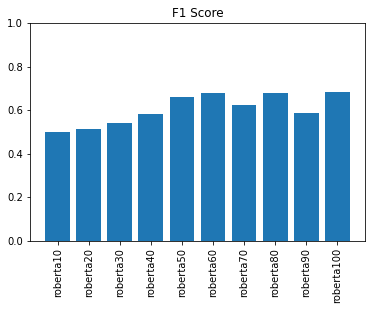

In [36]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3843553838725254, 0.38961312026913375, 0.4214030915576694, 0.4579716765646414, 0.5737602008788449, 0.5787965616045845, 0.5344561980075999, 0.5872809863724854, 0.48684889118102115, 0.5922803904170363]


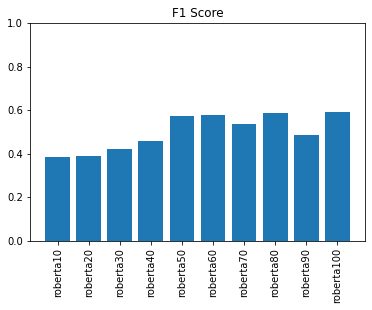

In [37]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.540318686624819, 0.5939865433137089, 0.6104637336504161, 0.6667428049337597, 0.7256748273697426, 0.7568563241915677, 0.6930265995686556, 0.7499459225611075, 0.6706549767921609, 0.7604259094942325]


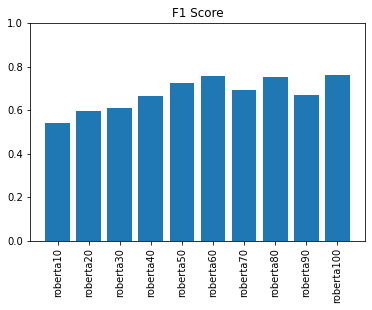

In [38]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.410912602607436, 0.4030698065601345, 0.43662306777645665, 0.46825034262220194, 0.5789914207993304, 0.5828898894801474, 0.5400020540207456, 0.591174561972745, 0.48891181021144914, 0.5953859804791481]


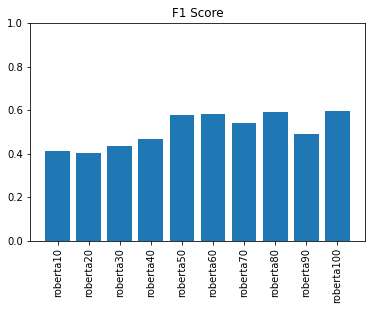

In [39]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.40338164251207737, 0.23560673162090345, 0.7280334728033473, 0.7766990291262136, 0.8367346938775511, 0.27629334849346215, 0.8424153166421207, 0.6898954703832753, 0.4827586206896553, 0.7461406518010291, 0.23277661795407098, 0.4519906323185011, 0.38305084745762713, 0.7418032786885246, 0.7181663837011885, 0.8927680798004988, 0.2220488819552782, 0.9555854643337819, 0.7545605306799336, 0.6538461538461537, 0.72, 0.2002871500358

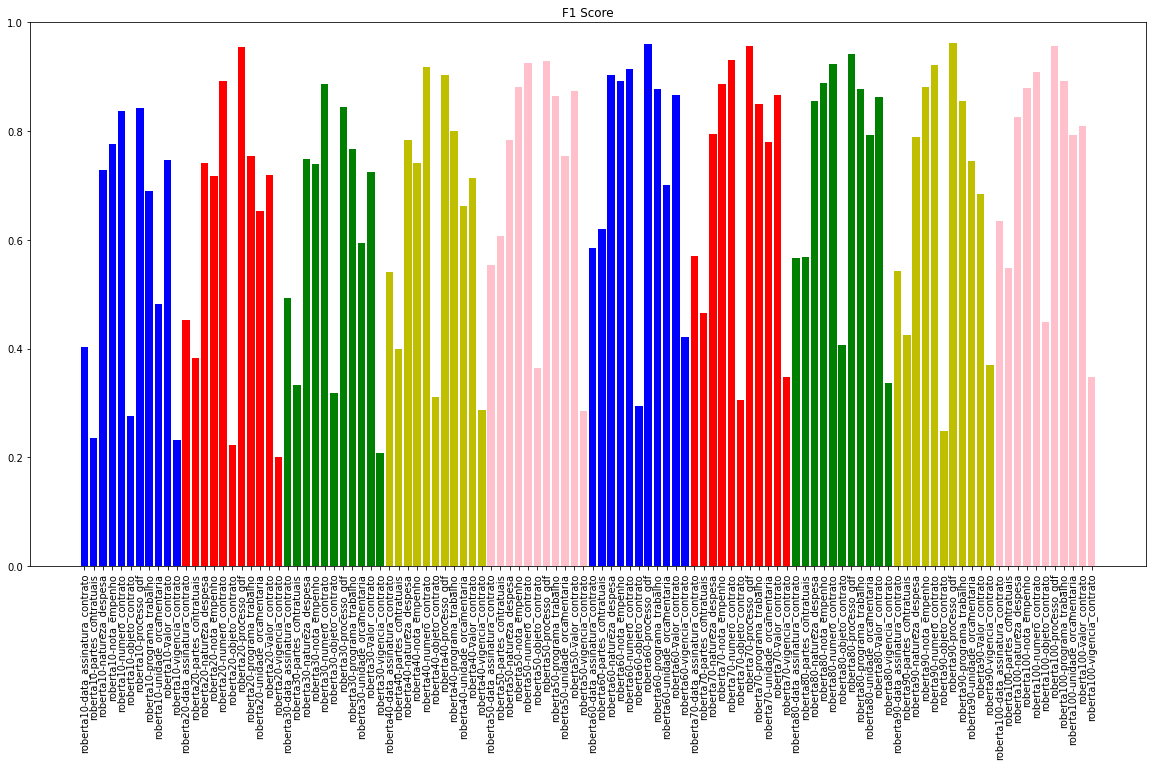

In [40]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11 + ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.40338164251207737, 0.23560673162090345, 0.7280334728033473, 0.7766990291262136, 0.8367346938775511, 0.27629334849346215, 0.8424153166421207, 0.6898954703832753, 0.4827586206896553, 0.7461406518010291, 0.23277661795407098, 0.4519906323185011, 0.38305084745762713, 0.7418032786885246, 0.7181663837011885, 0.8927680798004988, 0.2220488819552782, 0.9555854643337819, 0.7545605306799336, 0.6538461538461537, 0.72, 0.2002871500358

Text(0.5, 1.0, 'F1 Score')

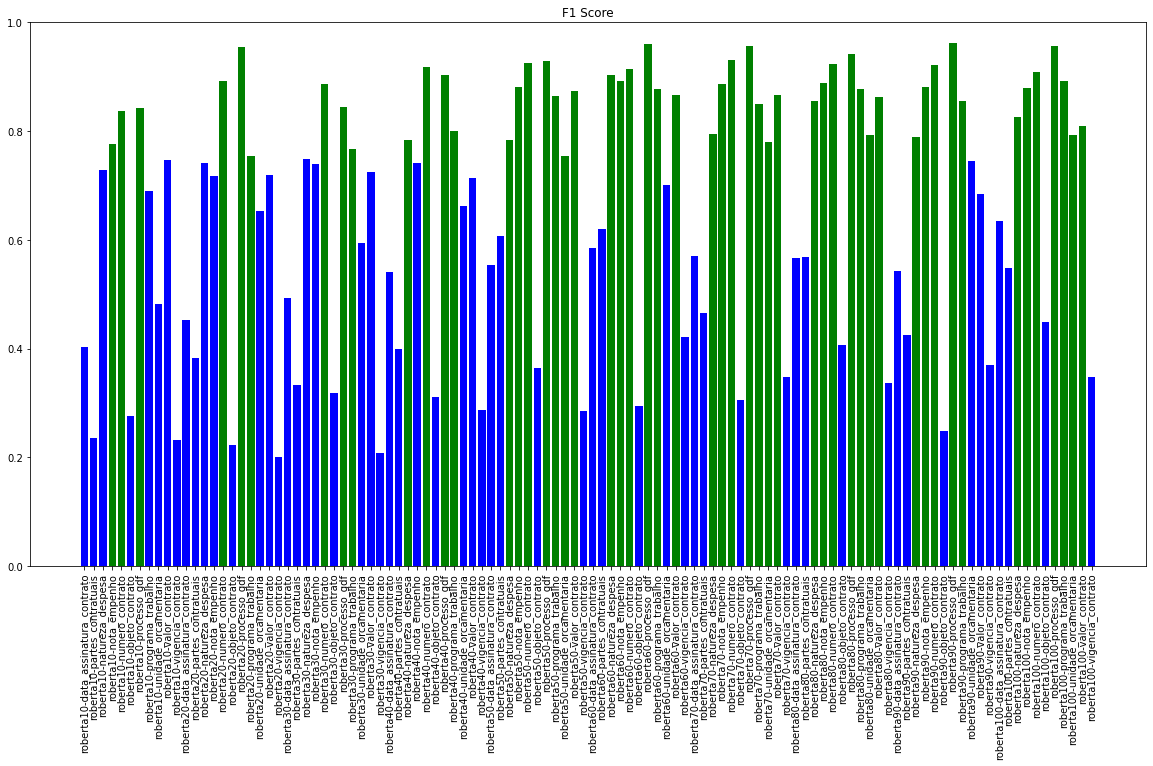

In [41]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*110

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5001207146306133, 0.5116694701429774, 0.5409036860879906, 0.5815440840566468, 0.6610169491525425, 0.6771387638149816, 0.6251412139262605, 0.6772658446895955, 0.5848375451263538, 0.6837843833185447]


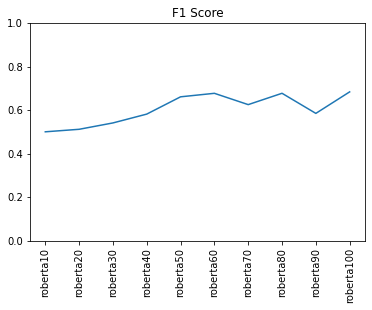

In [42]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['roberta10', 'roberta20', 'roberta30', 'roberta40', 'roberta50', 'roberta60', 'roberta70', 'roberta80', 'roberta90', 'roberta100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3843553838725254, 0.38961312026913375, 0.4214030915576694, 0.4579716765646414, 0.5737602008788449, 0.5787965616045845, 0.5344561980075999, 0.5872809863724854, 0.48684889118102115, 0.5922803904170363]


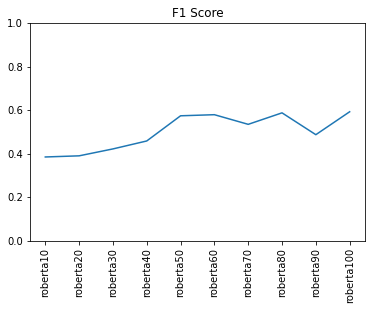

In [43]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()